In [1]:
from datetime import date
print(date.today())

2023-05-08


# 1. Normalisation & variance stabilisation

Objectives: 

1. Explain rationale behind normalisation/variance stabilisation
1. List options for normalisation/variance stabilisation
1. Explain their preference for one
1. Normalise a dataset
1. Demonstrate that the normalisation achieved the intended effect

### 1.1 Why is normalisation important?

- have students run without normalisation and see what happens.
- does normalisation distort/enhance biological signal?
- literature about normalisation:
    - [Comparison of transformations for single-cell RNA-seq data](https://www.nature.com/articles/s41592-023-01814-1)
    - [Validation of noise models for single-cell transcriptomics](https://www.nature.com/articles/nmeth.2930)
    - [The triumphs and limitations of computational methods for scRNA-seq](https://www.nature.com/articles/s41592-021-01171-x)
    - [Absolute scaling of single-cell transcriptomes identifies pervasive hypertranscription in adult stem and progenitor cells](https://www.cell.com/cell-reports/fulltext/S2211-1247(22)01882-4?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124722018824%3Fshowall%3Dtrue)

### 1.2 How do we normalise?

- challenge them to think about what we need. What does it mean if we normalise?
- What do we want to achieve with normalisation? Do we get it?
- Literature:
    - [Normalisation of single-cell RNA-seq counts by log(x+1)](https://academic.oup.com/bioinformatics/article/37/15/2223/6155989)
    - [Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)
    - [Pooling across cells to normalize single-cell RNA sequencing data with many zero counts](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7)
    - [Depth normalization for single-cell genomics count data](https://www.biorxiv.org/content/10.1101/2022.05.06.490859v1.full)

### 1.3 How do we evaluate if it worked?

- gold standard
- simulated data
- expert knowledge

## 1.1 Why normalise?

> [...] The data is available as a count matrix in the form of a numeric matrix of shape cells x genes. These counts represent the capture, reverse transcription and sequencing of a molecule in the scRNA-seq experiment. Each of these steps adds a degree of variability to the measured count depth for identical cells, so the difference in gene expression between cells in the count data might simply be due to sampling effects. This means that the dataset and therefore the count matrix still contains widely varying variance terms. Analyzing the dataset is often challenging as many statistical methods assume data with uniform variance structure.
>
> _Single-cell best practices_; Ch. 7 "Normalization"; Theis lab, commit [6c4befd](https://github.com/theislab/single-cell-best-practices/commit/6c4befda0a3246021a3083dfb27a5eab63f2ed32).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc

In [3]:
retina = "/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/chicken retina/"
raw = sc.read_h5ad(retina + "e16_raw.h5ad")

Remove genes that are not expressed in enough cells:

In [4]:
sc.pp.filter_genes(raw, min_cells=10)

Let's also keep track of some basic attributes for each cell and each gene so that we can refer to
them later:

In [5]:
sc.pp.calculate_qc_metrics(raw, percent_top=None, inplace=True)
raw.var["var_counts"] = np.var(raw.X, axis=0)

## 1.1 Why is normalisation important?

What happens if we don't normalize? What would we expect?

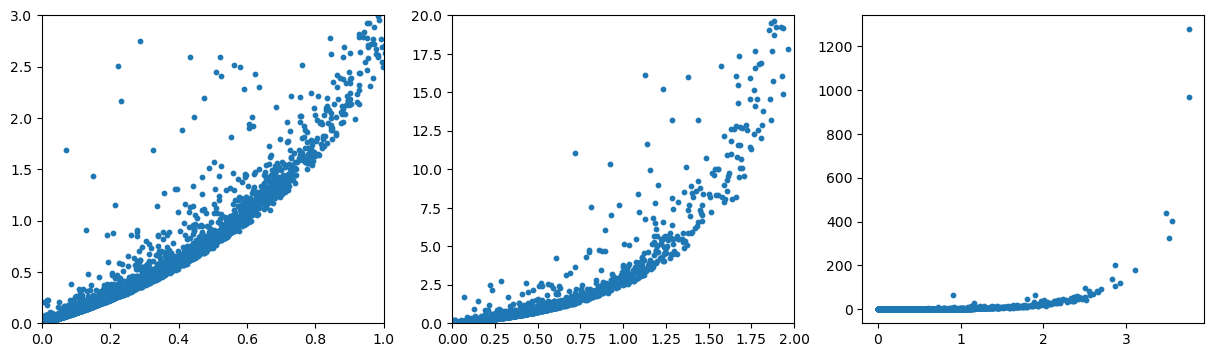

In [14]:
raw_mean = np.mean(raw.X, axis=0)
raw_var = np.var(raw.X, axis=0)

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0].scatter(np.log1p(raw_mean), raw_var, s=10)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 3)
ax[1].scatter(np.log1p(raw_mean), raw_var, s=10)
ax[1].set_xlim(0, 2)
ax[1].set_ylim(0, 20)
ax[2].scatter(np.log1p(raw_mean), raw_var, s=10)

We see that even though the x axis is in the log scale, the y axis grows exponentially. This means
that the variance of a gene's expression grows rapidly with higher average expression. What does
this mean when calculating distances?

Why is this bad? What does it mean in terms of distances? Let's plot the expression range of a
highly expressed gene and that of a gene with low average expression.

In [19]:
low_avg_genes = np.where(raw_mean < 0.1)[0]
mid_avg_genes = np.where((raw_mean >= 1) & (raw_mean < 5))[0]
high_avg_genes = np.where(raw_mean >= 10)[0]

In [20]:
low_avg = raw[:, low_avg_genes].copy()
mid_avg = raw[:, mid_avg_genes].copy()
high_avg = raw[:, high_avg_genes].copy()

In [23]:
sc.pp.neighbors(low_avg, n_neighbors=10, use_rep="X")
sc.tl.umap(low_avg)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


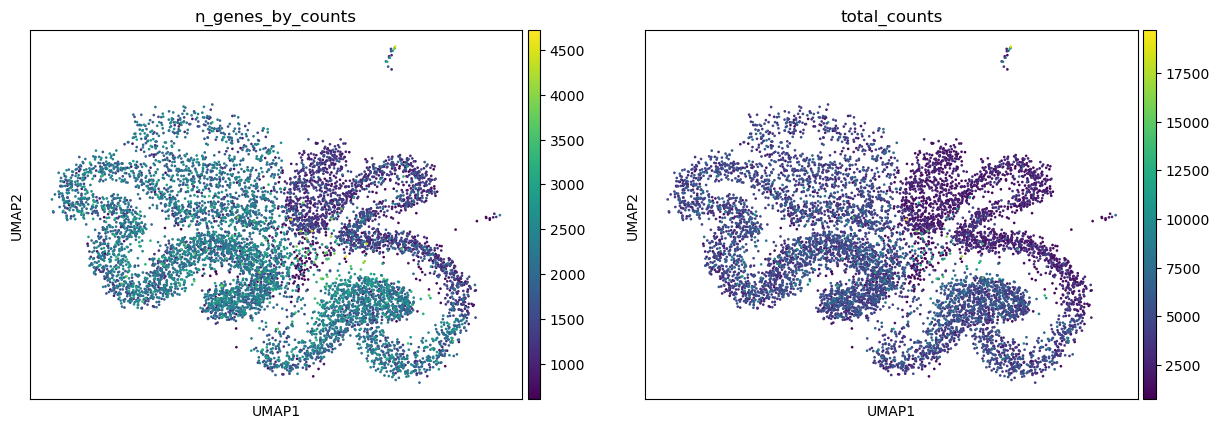

In [27]:
sc.pl.umap(low_avg, color=["n_genes_by_counts", "total_counts"])

In [28]:
sc.pp.neighbors(mid_avg, n_neighbors=10, use_rep="X")
sc.tl.umap(mid_avg)

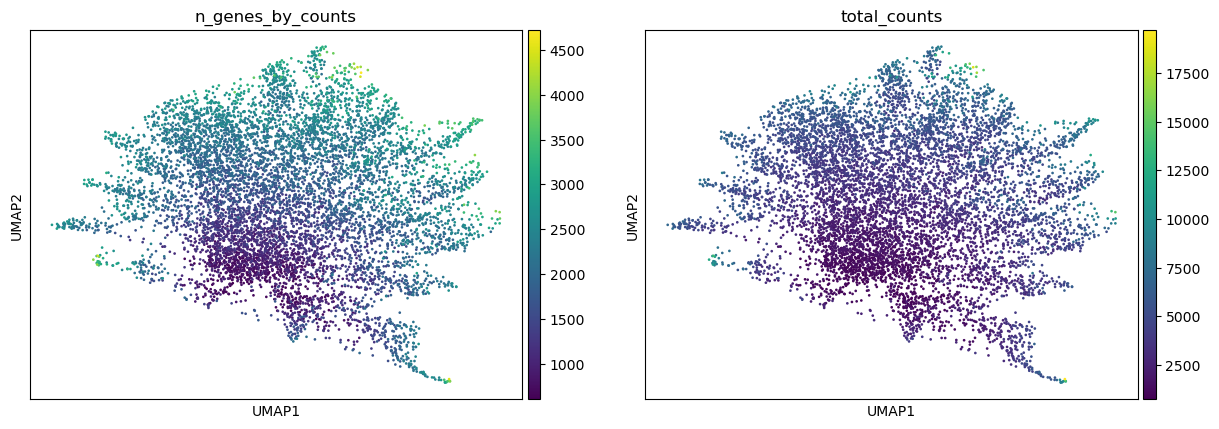

In [29]:
sc.pl.umap(mid_avg, color=["n_genes_by_counts", "total_counts"])

In [30]:
sc.pp.neighbors(high_avg, n_neighbors=10, use_rep="X")
sc.tl.umap(high_avg)

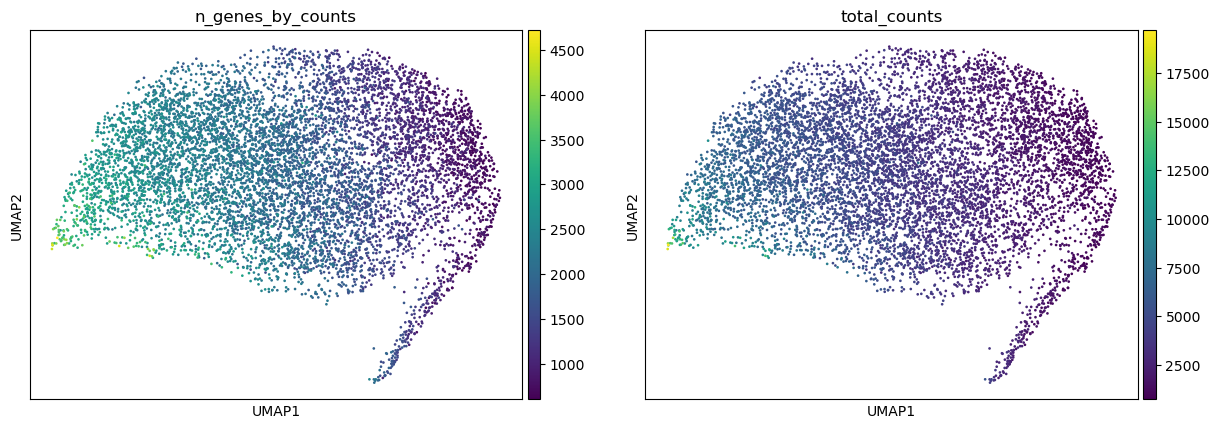

In [31]:
sc.pl.umap(high_avg, color=["n_genes_by_counts", "total_counts"])

In [ ]:
def approximately_equal(x, y, tol=0.01):
    return abs(x - y) < tol

In [ ]:
np.where(np.apply_along_axis(approximately_equal, 0, raw_var, 60, tol=5))

In [ ]:
# plot_discrete_histogram(raw, 1557)
fake_gene = raw.X[:, 1557].copy()
inflate = np.random.randint(0, len(fake_gene), 200)
fake_gene[inflate] += 10

In [ ]:
def plot_discrete_histogram(adata, gene, ax=None, layer=None):
    if layer is None:
        x = adata[:, gene].X
    else:
        x = adata[:, gene].layers[layer]
    xx = np.unique(x)
    y = np.array([np.sum(x == i) for i in xx])
    if ax is None:
        plt.bar(xx, y)
        plt.title(f"gene {gene}")
    else:
        ax.bar(xx, y)
        ax.set_title(f"gene {gene}")

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
plot_discrete_histogram(raw, 16380, ax=ax[0, 0])
ax[0, 0].xaxis.set_ticks([0, 1])
plot_discrete_histogram(raw, 2, ax=ax[0, 1])
plot_discrete_histogram(raw, 291, ax=ax[0, 2])
plot_discrete_histogram(raw, 390, ax=ax[1, 0])
plot_discrete_histogram(raw, 3526, ax=ax[1, 1])
# a fake bimodal gene
xx = np.unique(fake_gene)
y = np.array([np.sum(fake_gene == i) for i in xx])
ax[1,2].bar(xx, y)
ax[1,2].set_title("fake gene 1557");

In [ ]:
cells_to_keep = np.random.randint(0, len(raw), 400)
cells_to_keep = np.concatenate((cells_to_keep, inflate))

In [ ]:
from scipy.sparse import csr_matrix, issparse

In [ ]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(raw, inplace=False)
raw.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(raw.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    raw.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

In [ ]:
raw.obsm["X_pca"] = sc.pp.pca(raw.layers["analytic_pearson_residuals"], chunked=True)

In [ ]:
sc.pp.neighbors(raw, use_rep="X_pca", n_neighbors=30, metric="cosine")
sc.tl.umap(raw, min_dist=0.5)

In [ ]:
sc.pl.umap(raw, color=["total_counts", "n_genes_by_counts"], cmap="magma_r")

In [ ]:
# cherrypicked = np.zeros((cells_to_keep.shape[0], 6))
# cherrypicked[:, :5] = raw.X[cells_to_keep][:, [16380, 2, 291, 390, 3526]].copy()
# cherrypicked[:, 5] = fake_gene[cells_to_keep].copy()


# cherrypicked[:, 5] = fake_gene[cells_to_keep].copy()

In [ ]:
# Define two cells with different total transcript counts
cell_a = np.random.normal(loc=5, scale=2, size=1000)
cell_b = np.random.normal(loc=10, scale=3, size=5000)

# Plot the distribution of transcript counts for each cell
sns.histplot(cell_a, color='red', alpha=0.5, label='Cell A')
sns.histplot(cell_b, color='blue', alpha=0.5, label='Cell B')
plt.legend()
plt.xlabel('Transcript count')
plt.ylabel('Frequency')
plt.title('Distribution of transcript counts in two cells')
plt.show()


In [ ]:
adata

In [ ]:

# faked = np.zeros(toy.shape[0], dtype=str)
# faked[400:] = "1"
# toy.obs["faked"] = faked.copy()

In [ ]:
# sc.pp.pca(toy)


In [ ]:
cherrypicked = raw.X[cells_to_keep][:, [16380, 2, 291, 390]].copy()
toy = sc.AnnData(cherrypicked)
sc.pp.neighbors(toy, use_rep="X")
mat = toy.obsp["distances"].todense()
sns.heatmap(mat>0, cmap="magma_r")

In [ ]:
cherrypicked = raw.X[cells_to_keep][:, [291, 390]].copy()
toy = sc.AnnData(cherrypicked)
sc.pp.neighbors(toy, use_rep="X")
mat = toy.obsp["distances"].todense()
sns.heatmap(mat>0, cmap="magma_r")

In [ ]:
sns.clustermap(mat>0, cmap="magma_r")

In [ ]:
sc.tl.pca(toy)
# sc.pl.pca(toy)

### Effectiveness

([Chapter 6b](https://github.com/hemberg-lab/scRNA.seq.course/blob/master/course_files/06b-Normalization.Rmd#L82) of the [Hemberg lab scRNA-seq course](https://github.com/hemberg-lab/scRNA.seq.course)).

To compare the efficiency of different normalization methods we will use visual inspection of `PCA` plots and calculation of cell-wise _relative log expression_ via `scater`'s `plotRLE()` function. Namely, cells with many (few) reads have higher (lower) than median expression for most genes resulting in a positive (negative) _RLE_ across the cell, whereas normalized cells have an _RLE_ close to zero. Example of a _RLE_ function in `R`:

__Note__ The __RLE__, __TMM__, and __UQ__ size-factor methods were developed for bulk RNA-seq data and, depending on the experimental context, may not be appropriate for single-cell RNA-seq data, as their underlying assumptions may be problematically violated. 

__Note__ `scater` acts as a wrapper for the `calcNormFactors` function from `edgeR` which implements several library size normalization methods making it easy to apply any of these methods to our data.

__Note__ `edgeR` makes extra adjustments to some of the normalization methods which may result in somewhat different results than if the original methods are followed exactly, e.g. edgeR's and scater's "RLE" method which is based on the "size factor" used by [DESeq](http://bioconductor.org/packages/DESeq) may give different results to the `estimateSizeFactorsForMatrix` method in the `DESeq`/`DESeq2` packages. In addition, some versions of `edgeR` will not calculate the normalization factors correctly unless `lib.size` is set at 1 for all cells.

__Note__ For __CPM__ normalisation we use `scater`'s `calculateCPM()` function. For __RLE__, __UQ__ and __TMM__ we used to use `scater`'s `normaliseExprs()` function (it is deprecated now and therefore we removed the corresponding subchapters). For __scran__ we use `scran` package to calculate size factors (it also operates on `SingleCellExperiment` class) and `scater`'s `normalize()` to normalise the data. All these normalization functions save the results to the `logcounts` slot of the `SCE` object. For __downsampling__ we use our own functions shown above.